 Use jupyter notebook to load all of the fits files, and try to plot them all onto one figure (see example which is a very simple one I made for another galaxy) so that you can visualize them nicely. The cutouts are 200x200 pixels I believe, so you can crop them around the galaxy, which is at the center.

1. Load in libraries & data, explore it.
*(What is the data?)*

In [1]:
from astropy.io import fits 
import matplotlib.pyplot as plt
import numpy as np
# core libs for coords and scales:
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.patches as patches

#from sedpy import observate
import os

# solves an error from our function that happens because of some distortion coefficient nonsense 
# between astropy and drizzled HST images. use to fix your header before running WCS(header).
def strip_SIP(header):
    A_prefixes = [i for i in header.keys() if i.startswith('A_')]
    B_prefixes = [i for i in header.keys() if i.startswith('B_')]
    for a,b in zip(A_prefixes,B_prefixes):
        del header[a]
        del header[b]
    return header

# fn to easily load fits files
def load_fits(fpath,extension=0):
    '''
    Function to load a FITs file into Python

    Parameters
    ----------
    fpath: str
        path to the FITS file to load. must end in .fit/.fits/.FIT/.FITS
    extension: int (optional)
        extension of the FITS file to load. (default 0)
    
    Returns
    -------
    header: dict_like
        the read in header of the chosen extension, as a python dictionary
    data: array_like
        the data contained in the extension, whether an image or table.
    '''
    with fits.open(fpath) as hdu:
        header = hdu[extension].header
        data = hdu[extension].data
    return header, data       

In [2]:
file_core = r"D:\Programming\Cambridge\Enso Data\191250_cutouts\191250_"
# define filter list
filter_list = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F277W", "F356W", "F410M", "F444W"]

PSF_list = [0.033, 0.040, 0.050, 0.062, 0.066, 0.071, 0.092, 0.116, 0.137, 0.145]

# test file = ftest
ftest = (file_core + filter_list[3] + '.fits')
testPSF = PSF_list[9]
header, data = load_fits(ftest)
#hdu_list = fits.open(ftest)
#hdu_list.info()
#image_data = hdu_list[1].data
#hdu_list.close()

with fits.open(ftest) as hdul:
    image_data = hdul[1].data
    pixel_area = hdul[0].header['PIXAR_A2']
    pixel_scale = np.sqrt(pixel_area)
    noise = hdul[2].data
    print(pixel_scale)
    # print(sig_noise)
    f = hdul.info()

0.02999474280021024
Filename: D:\Programming\Cambridge\Enso Data\191250_cutouts\191250_F182M.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     437   ()      
  1  SCI           1 ImageHDU        36   (200, 200)   float32   
  2  ERR           1 ImageHDU        36   (200, 200)   float32   
  3  EXP           1 ImageHDU        36   (200, 200)   float32   
  4  WHT           1 ImageHDU        36   (200, 200)   float32   


In [3]:
# Turn the above into a streamlined function
def zoomer(header, image_data):
    
    # fn to take header & image data and provide a zoom on central square
    # Map pixels to WCS coords
    wcs = WCS(header)
    wcs

    # singling out center of image (to focus on Enso)
    coords = wcs.array_index_to_world(100,100)
    RA = coords.ra.deg
    DEC =  coords.dec.deg
    galaxy_position = SkyCoord(ra=RA * u.deg, dec=DEC *u.deg)
    image_cutout = Cutout2D(image_data, galaxy_position, (50,50), wcs=wcs).data
    return image_cutout

Set OBSGEO-B to    21.600401 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234207865.831 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    21.600401 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234207865.831 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.090597 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234812278.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.090597 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234812278.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.588408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1237564059.407 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.588408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1237564059.407 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.975280 from OBSGEO-[XYZ].
Set OBSGEO-H to 1503141563.916 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.975280 from OBSGEO-[XYZ].
Set OBSGEO-H to 1503141563.916 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.090550 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Text(0, 0.5, 'Mean Signal to Noise')

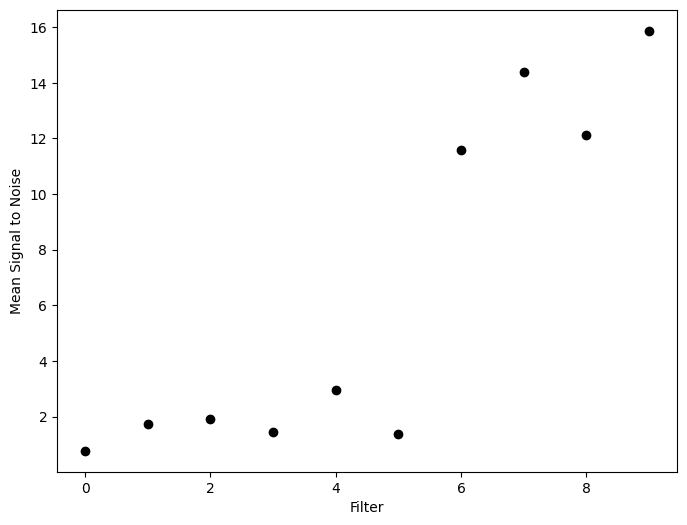

In [4]:
SNRs = []

# for i in range(0, len(filter_list)):
#     f = file_core + filter_list[i] + '.fits'
#     with fits.open(f) as hdul:
#         image_data = hdul[1].data
#         noise = hdul[2].data
#         sig_noise = image_data / noise
#         SNRs.append(sig_noise)


for i, f in enumerate(filter_list):
        # load image data
        fname = (file_core + f + '.fits')
        with fits.open(fname) as hdul:
            image_data = hdul[1].data
            header = hdul[1].header
            noise = hdul[2].data
            
                    
        zoomed_im = zoomer(header, image_data)
        zoomed_noise = zoomer(header, noise)
        # calculate SNR
        sig_noise = zoomed_im / zoomed_noise   
        SNRs.append(sig_noise)
        mean_SNRs = [np.mean(i) for i in SNRs]
mean_SNRs

# plot mean SNR for each filter
plt.figure(figsize=(8, 6))
plt.plot(mean_SNRs, 'o', label='Mean Signal to Noise', color='black')
plt.xlabel("Filter")
plt.ylabel("Mean Signal to Noise")


# mean_SNRs = [np.mean(i) for i in SNRs]

# print(mean_SNRs)
# # Assuming sig_noise is already defined
# plt.figure(figsize=(8, 6))
# plt.plot(sig_noise, 'o-', label='Signal to Noise', color='black')
# plt.xlabel("Index")
# plt.ylabel("Signal to Noise")
# plt.title("Signal to Noise Plot")
# plt.legend()
# plt.grid()
# plt.show()

"SCI: 2-D data array containing the pixel values, in units of surface brightness"

"ERR: 2-D data array containing uncertainty estimates for each pixel. These values are based on the combined VAR_POISSON and VAR_RNOISE data (see below), given as standard deviation."

"WHT: 2-D weight image giving the relative weight of the output pixels"

"EXP: **Not sure, but likely exposure something...? Times?**"

In [5]:
load_fits(ftest, extension=1)

(XTENSION= 'IMAGE   '           / Image extension                                
 BITPIX  =                  -32 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                  200                                                  
 NAXIS2  =                  200                                                  
 PCOUNT  =                    0 / number of parameters                           
 GCOUNT  =                    1 / number of groups                               
 WCSAXES =                    2 / Number of coordinate axes                      
 CRPIX1  =              -2136.5 / Pixel coordinate of reference point            
 CRPIX2  =               3822.5 / Pixel coordinate of reference point            
 PC1_1   =                 -1.0 / Coordinate transformation matrix element       
 CDELT1  =  8.3318730000584E-06 / [deg] Coordinate increment at reference point  
 CDELT2  =  8.33

In [6]:
# Getting restframe wlengths:
from astropy.cosmology import Planck18 as cosmo
from sedpy import observate 
import asdf
filterlist = observate.load_filters(["jwst_" + f for f in filter_list])


redshift = 5.3
pix_scale = 0.03  # ??
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60
wv_list = np.array([filterlist[:][ii].wave_effective/1e4 for ii in range(len(filter_list))])
rest_wvs = wv_list/(1+redshift)
print("Filter wavelengths: ", wv_list)
print("Rest wavelengths: ", rest_wvs)

Filter wavelengths:  [0.89824364 1.14859202 1.49442228 1.84236203 1.97811383 2.09374694
 2.76120868 3.54834844 4.07932817 4.37878307]
Rest wavelengths:  [0.14257836 0.18231619 0.23720989 0.29243842 0.31398632 0.33234078
 0.43828709 0.56322991 0.64751241 0.69504493]


In [7]:
# # take a peek at the image
# reduced_image = image_data - sig_noise
# plt.imshow(image_data, cmap='coolwarm', origin='lower')
# plt.colorbar()

Want images from every filter plotted side by side (11 total), and need to zoom on galaxy.

Text(0, 0.5, 'N')

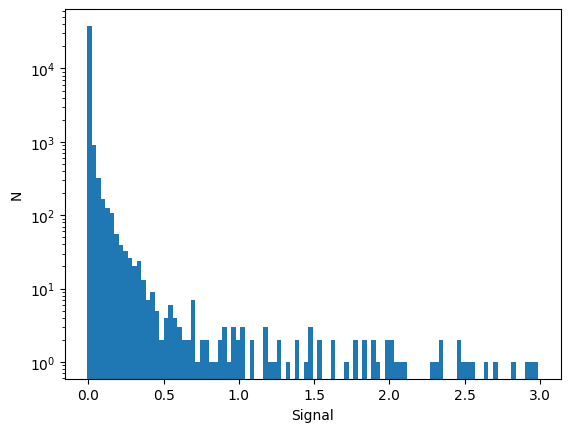

In [8]:
# check hist to clarify vmin/max
plt.hist(image_data.flatten(), log=True, bins=100)
plt.xlabel('Signal')
plt.ylabel('N')

In [9]:
# Map pixels to WCS coords
wcs = WCS(header)
wcs

Set OBSGEO-B to    23.044721 from OBSGEO-[XYZ].
Set OBSGEO-H to 1236397528.843 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : np.float64(53.122781107619) np.float64(-27.805160455556) 
CRPIX : np.float64(-2136.5) np.float64(3822.5) 
PC1_1 PC1_2  : np.float64(-1.0) np.float64(0.0) 
PC2_1 PC2_2  : np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(8.3318730000584e-06) np.float64(8.3318730000584e-06) 
NAXIS : 200  200

In [10]:
# singling out center of image (to focus on Enso)
coords = wcs.array_index_to_world(100,100)
RA = coords.ra.deg
DEC =  coords.dec.deg
galaxy_position = SkyCoord(ra=RA * u.deg, dec=DEC *u.deg)


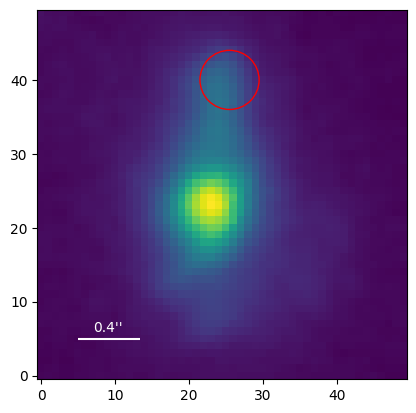

In [11]:
# cutting out around Enso with a scalebar
image_cutout = Cutout2D(image_data, galaxy_position, (50,50), wcs=wcs).data
plt.imshow(image_cutout, origin='lower')

# scalebar creation
n_pix_arcsec = 1 / pixel_scale
n_pix_arcsec
# multiply this guy by the width of the PSF; i.e. n_pix_arcsec * PSF FWHM Arcsec
PSF_radius = (n_pix_arcsec * testPSF)/2 # pixels per arcsecond, multiplied by the PSF in arcseconds, gives the width/radius of PSF in pixels

plt.hlines(5,5, (n_pix_arcsec *0.4), color='white')
plt.text(7,6, "0.4''", color='white')

circle = patches.Circle((25.5, 40), radius=4, edgecolor='red', facecolor='none', lw=1)
plt.gca().add_patch(circle)

plt.show()

In [12]:
# COLORBAR SORCERY (to set cbar height within axes, not image height)
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

Set OBSGEO-B to    23.044721 from OBSGEO-[XYZ].
Set OBSGEO-H to 1236397528.843 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


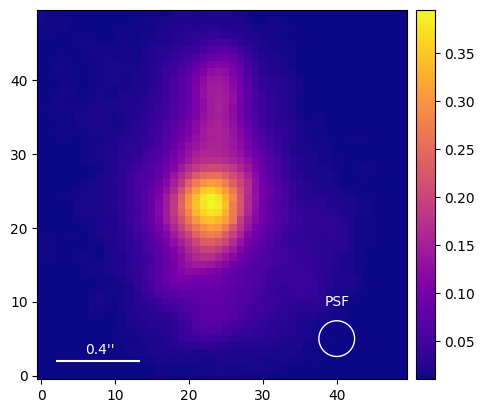

In [13]:


def arcscalebar(arcscale, color):
    # scalebar creation
    plt.hlines(2,2, (n_pix_arcsec *arcscale), color=color)
    plt.text(6,3, "0.4''", color='white')
    return

zoomed = zoomer(header, image_data)

x_center, y_center = 40, 5  # Example coordinates for the center of the circle
# Create a Circle patch
circle = patches.Circle((x_center, y_center), radius=PSF_radius, edgecolor='white', facecolor='none', lw=1)
# Add the circle to the plot
fig, ax = plt.subplots()
add_colorbar(ax.imshow(zoomed, cmap='plasma', origin='lower', vmin=0.01))
ax.add_patch(circle)
# Step 4: Add a small title "PSF" above the circle
plt.text(x_center, y_center + PSF_radius + 2, 'PSF', color='white', ha='center', fontsize=10)

plt.imshow(zoomed, cmap='plasma', origin='lower', vmin=0.01)
arcscalebar(0.4,'white')

RGB Image
========

In [14]:
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

# want filter_list 2, 6, 9

rgb_list = ["F150W", "F210M", "F356W"]

g_name = (file_core + rgb_list[0] + '.fits')
r_name = (file_core + rgb_list[1] + '.fits')
i_name = (file_core + rgb_list[2] + '.fits')

with fits.open(g_name) as hdul:
    g = image_data = hdul[1].data
    header = hdul[1].header
    # g = zoomer(header,image_data)
with fits.open(r_name) as hdul:
    r = image_data = hdul[1].data
    header = hdul[1].header
    # r = zoomer(header,image_data)
with fits.open(i_name) as hdul:
    i = image_data = hdul[1].data
    header = hdul[1].header
    # i = zoomer(header,image_data)

In [15]:
import numpy as np

print("Min:", np.min(i))
print("Max:", np.max(i))
print("Mean:", np.mean(i))
print("Std:", np.std(i))

Min: -0.0059169615
Max: 2.792538
Mean: 0.0073335334
Std: 0.070502184


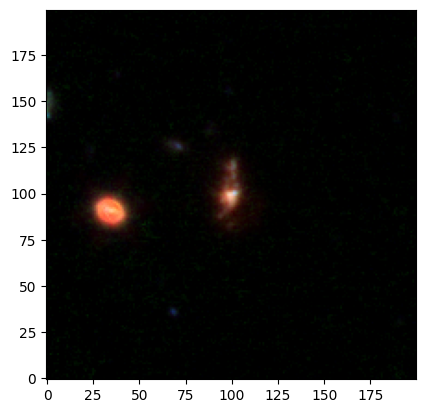

In [16]:

rgb_default = make_lupton_rgb(i, r, g, minimum=0.002, stretch=0.3, Q=1)
plt.imshow(rgb_default, origin='lower')

Set OBSGEO-B to    23.588408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1237564059.407 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    21.445878 from OBSGEO-[XYZ].
Set OBSGEO-H to 1541791521.761 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.225686 from OBSGEO-[XYZ].
Set OBSGEO-H to 1235003121.785 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


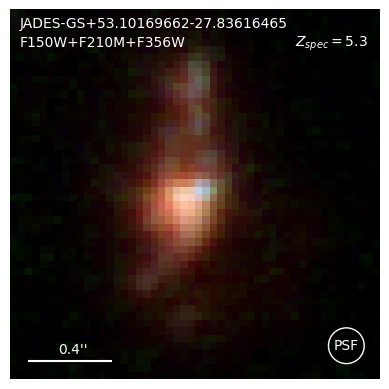

In [17]:
rgb_list = ["F150W", "F210M", "F356W"]

g_name = (file_core + rgb_list[0] + '.fits')
r_name = (file_core + rgb_list[1] + '.fits')
i_name = (file_core + rgb_list[2] + '.fits')

with fits.open(g_name) as hdul:
    image_data = hdul[1].data
    header = hdul[1].header
    g = zoomer(header,image_data)
with fits.open(r_name) as hdul:
    image_data = hdul[1].data
    header = hdul[1].header
    r = zoomer(header,image_data)
with fits.open(i_name) as hdul:
    image_data = hdul[1].data
    header = hdul[1].header
    i = zoomer(header,image_data)
    
rgb_default = make_lupton_rgb(i, r, g, minimum=0.002, stretch=0.3, Q=1)
# plt.imshow(rgb_default, origin='lower')


x_center, y_center = 45, 4  # Example coordinates for the center of the circle
# Create a Circle patch
circle = patches.Circle((x_center, y_center), radius=PSF_radius, edgecolor='white', facecolor='none', lw=1)
# Add the circle to the plot
fig, ax = plt.subplots()
# add_colorbar(ax.imshow(rgb_default, origin='lower'))
ax.add_patch(circle)
ax.set_axis_off()
# Step 4: Add a small title "PSF" above the circle
plt.text(x_center, y_center-.5, 'PSF', color='white', ha='center', fontsize=10)

# Add info text
plt.text(19, 47, 'JADES-GS+53.10169662-27.83616465', color='white', ha='center', fontsize=10)
plt.text(12, 44.5, 'F150W+F210M+F356W', color='white', ha='center', fontsize=10)
plt.text(43, 44.5, r'$Z_{spec}=5.3$', color='white', ha='center', fontsize=10)


plt.imshow(rgb_default, origin='lower')
# plt.imshow(zoomed, cmap='plasma', origin='lower', vmin=0.01)

arcscalebar(0.4,'white')
# plt.savefig('Enso_RGB.pdf', bbox_inches='tight')
# help(plt.savefig)


Text(40, 9.417090237542954, 'PSF')

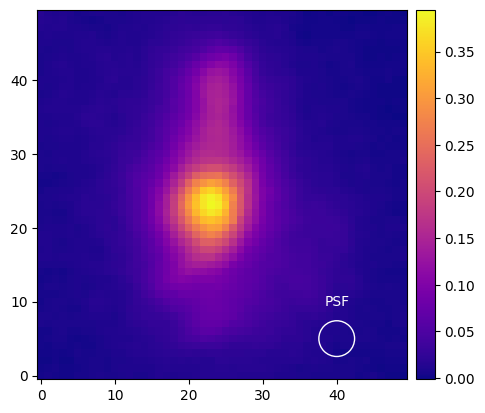

In [18]:
def zoomer(header, image_data):
    
    # fn to take header & image data and provide a zoom on central square
    # Map pixels to WCS coords
    wcs = WCS(header)
    wcs

    # singling out center of image (to focus on Enso)
    coords = wcs.array_index_to_world(100,100)
    RA = coords.ra.deg
    DEC =  coords.dec.deg
    galaxy_position = SkyCoord(ra=RA * u.deg, dec=DEC *u.deg)
    image_cutout = Cutout2D(image_data, galaxy_position, (50,50), wcs=wcs).data
    return image_cutout

def arcscalebar(arcscale, color):
    # scalebar creation
    plt.hlines(5,5, (n_pix_arcsec *arcscale), color=color)
    plt.text(7,6, "0.4''", color='white')
    plt.show()
    return

x_center, y_center = 40, 5  # Example coordinates for the center of the circle
# Create a Circle patch
circle = patches.Circle((x_center, y_center), radius=PSF_radius, edgecolor='white', facecolor='none', lw=1)
# Add the circle to the plot
fig, ax = plt.subplots()
add_colorbar(ax.imshow(zoomed, cmap='plasma', origin='lower'))
ax.add_patch(circle)
# Step 4: Add a small title "PSF" above the circle
plt.text(x_center, y_center + PSF_radius + 2, 'PSF', color='white', ha='center', fontsize=10)


In [19]:
print("1st percentile:", np.percentile(zoomed, 1))
print("99th percentile:", np.percentile(zoomed, 99))
print("0.1 percentile:", np.percentile(zoomed, 0.1))
print("99.9 percentile:", np.percentile(zoomed, 99.9))

1st percentile: 0.0007353356
99th percentile: 0.30664963
0.1 percentile: -0.00051252695
99.9 percentile: 0.38135073


Set OBSGEO-B to    21.600401 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234207865.831 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.090597 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234812278.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.588408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1237564059.407 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.975280 from OBSGEO-[XYZ].
Set OBSGEO-H to 1503141563.916 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.090550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1236488117.978 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    21.445878 from OBSGEO-[XYZ].
Set OBSGEO-H to 1541791521.761 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.046898 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234752813.098 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.225686 from OBSGEO-[XYZ].
Set OBSGEO-H to 1235003121.785 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.166459 from OBSGEO-[XYZ].
Set OBSGEO-H to 

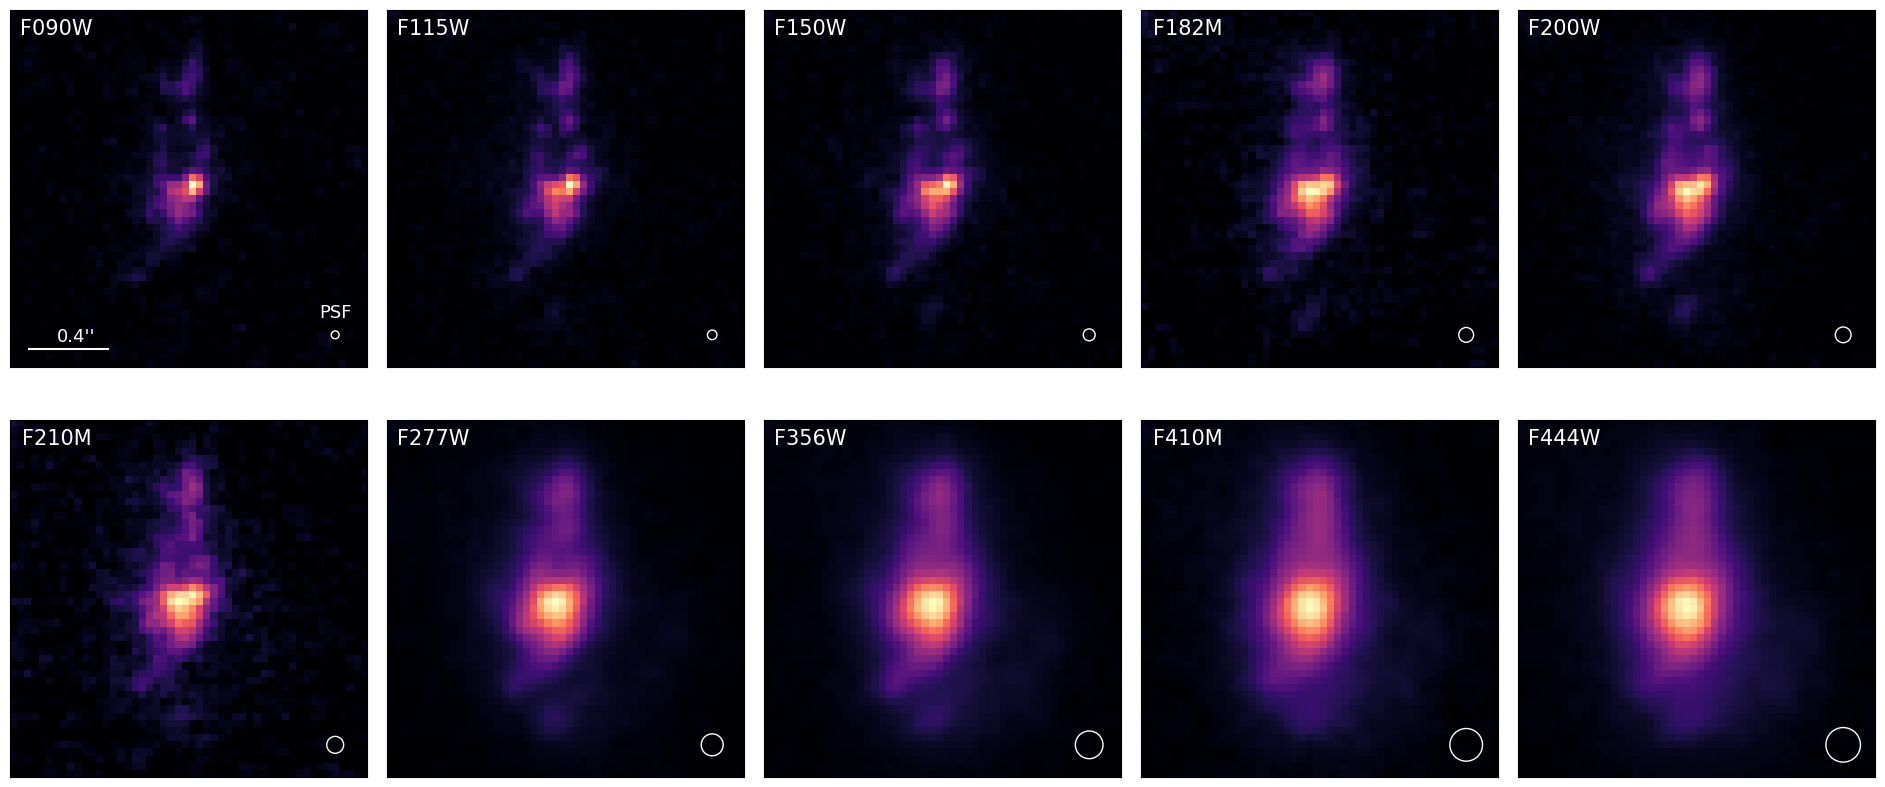

In [20]:
from astropy.visualization import simple_norm

def arcscalebar(arcscale, color):
    # scalebar creation
    plt.hlines(5,5, (n_pix_arcsec *arcscale), color=color)
    plt.text(7,6, "0.4''", color='white')
    plt.show()
    return



# ChatGPT's version of the above
def FITS_plotter(filters, h=2, w=5, cmap='magma'):
    fig, axes = plt.subplots(h, w, figsize=(20, 10))
    plt.subplots_adjust(hspace=0.15)
    #plt.suptitle("Enso-z5", fontsize=18, y=0.95)
    
    for i, f in enumerate(filters):
        ax = axes.flat[i]
        # load image data
        fname = (file_core + f + '.fits')
        with fits.open(fname) as hdul:
            image_data = hdul[1].data
            header = hdul[1].header
        
        filter_PSF = PSF_list[i]   
        zoomed = zoomer(header, image_data)

        mu = np.mean(image_data)
        s = np.std(image_data)
        scale = 2
        # dvmin = mu - scale*s
        # dvmax = mu + scale*s
        norm = simple_norm(image_data, 'asinh', percent=99.8)
        vmin, vmax = np.percentile(image_data, (0.03, 99))
        # norm = simple_norm(zoomed, 'asinh', min_cut=0.00006, max_cut=0.3239)

        im = ax.imshow(zoomed, origin='lower', cmap=cmap, norm='asinh', vmin=0.0001)
        # ax.set_title(f'{filters[i]}'.upper())
        PSF_radius = (n_pix_arcsec * filter_PSF)/2
        x_center, y_center = 45, 4        # Create a Circle patch
        circle = patches.Circle((x_center, y_center), radius=PSF_radius, edgecolor='white', facecolor='none', lw=1)
        ax.add_patch(circle)
        ax.text(6, 46, f'{filters[i]}'.upper(), color='white', ha='center', fontsize=15)


        # Remove x and y axis values
        ax.set_xticks([])
        ax.set_yticks([])

    # add psf text
    axes[0][0].text(x_center, y_center + PSF_radius, 'PSF', color='white', ha='center', fontsize=13)


    # # Add a single colorbar for the entire figure
    # cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
    axes[0][0].hlines(2,2, (n_pix_arcsec *0.4), color='white')
    axes[0][0].text(6,3, "0.4''", color='white', fontsize=13)
    # add_colorbar(im)
    # arcscalebar(0.4,'white')

    fig.subplots_adjust(right=0.83)
    # cbar_ax = fig.add_axes([0.96, 0.087, 0.013, 0.77])
    # fig.colorbar(im, cax=cbar_ax)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])  
    plt.savefig('enso_magma.pdf', dpi=300, bbox_inches='tight')
    plt.show()

FITS_plotter(filter_list, cmap='magma')


Single Sersic Fits as a fn of Wavelength
=======================================

In [21]:
import asdf
from sedpy import observate

In [22]:
path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'

file_path = os.path.join(path_wdir, 'Output', f'fit_{filter_list[5]}.asdf')

filter_list = ["f090w", "f115w", "f150w", "f182m", "f200w", "f210m", "f277w", "f356w", "f410m", "f444w"]
filterlist = observate.load_filters(["jwst_" + f for f in filter_list])

af = asdf.open(file_path)

af.info()
r_eff = af["posterior"]['r_eff']


# r_eff_quantiles = 
params_single = list(af['posterior'].keys())

#for example, 16ht percentile for the first parameter 
param_a = params_single[3]
param_a_16 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 16)
param_a_84 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 84)

print(param_a_16, param_a_84)


root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.5.0
├─history (dict)
│ └─extensions (list) ...
├─input_data (dict)
│ ├─image (NDArrayType): shape=(50, 50), dtype=float32
│ ├─mask (NDArrayType): shape=(50, 50), dtype=bool
│ ├─psf (NDArrayType): shape=(37, 37), dtype=float32
│ └─rms (NDArrayType): shape=(50, 50), dtype=float32
├─loss_func (str): <function student_t_loss_free_sys at 0x000001FA74E2BE20>
├─method_used (str): sampling
├─posterior (dict)
│ ├─ellip (NDArrayType): shape=(2, 1000), dtype=float32
│ ├─flux (NDArrayType): shape=(2, 1000), dtype=float32
│ ├─n (NDArrayType): shape=(2, 1000), dtype=float32
│ ├─r_eff (NDArrayType): shape=(2, 1000), dtype=float32
│ └─4 not shown
├─prior_info (str)
└─rendere_type (str): <class 'pysersic.rendering.HybridRenderer'>
Some nodes not shown.
6.82264 7.4016056


In [23]:
r_eff_asec = r_eff * pixel_scale
r_eff_asec
r_eff_pc = 1/r_eff_asec
r_eff_asec

redshift = 5.3
pix_scale = 0.03  # ??
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60

r_eff_asec*kpc_per_arcsec

array([[1.39248534, 1.34875198, 1.36104979, ..., 1.42094139, 1.41335543,
        1.30575099],
       [1.35776665, 1.3507662 , 1.39881968, ..., 1.26563588, 1.30775148,
        1.27618778]])

In [24]:
help(plt.errorbar)

Help on function errorbar in module matplotlib.pyplot:

errorbar(x: 'float | ArrayLike', y: 'float | ArrayLike', yerr: 'float | ArrayLike | None' = None, xerr: 'float | ArrayLike | None' = None, fmt: 'str' = '', *, ecolor: 'ColorType | None' = None, elinewidth: 'float | None' = None, capsize: 'float | None' = None, barsabove: 'bool' = False, lolims: 'bool | ArrayLike' = False, uplims: 'bool | ArrayLike' = False, xlolims: 'bool | ArrayLike' = False, xuplims: 'bool | ArrayLike' = False, errorevery: 'int | tuple[int, int]' = 1, capthick: 'float | None' = None, data=None, **kwargs) -> 'ErrorbarContainer'
    Plot y versus x as lines and/or markers with attached errorbars.

    *x*, *y* define the data locations, *xerr*, *yerr* define the errorbar
    sizes. By default, this draws the data markers/lines as well as the
    errorbars. Use fmt='none' to draw errorbars without any data markers.

    .. versionadded:: 3.7
       Caps and error lines are drawn in polar coordinates on polar plots.

In [25]:
# r_eff_errors_upper

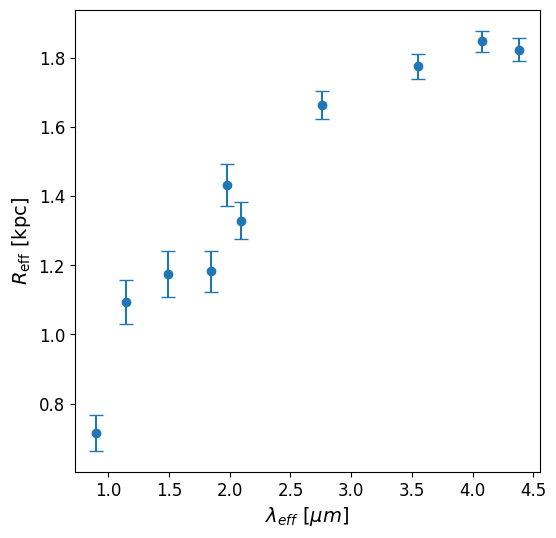

In [26]:
import asdf
from astropy.cosmology import Planck18 as cosmo 

# Define the path to the directory containing the ASDF files
path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'

wavelengths = []
for i in filterlist:
    wavelengths.append(i.wave_effective/10000)

r_effs_kpc = []
r_eff_errors_lower = []
r_eff_errors_upper = []

for filter_name in filter_list:
    file_path = os.path.join(path_wdir, 'Output', f'fit_{filter_name}.asdf')
    with asdf.open(file_path) as af:
        r_eff = af["posterior"]['r_eff'].mean()  # Adjust the key to match the structure of your ASDF file
        redshift = 5.3
        pix_scale = 0.03  # taken from .fits value; arcsec/pixel
        kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60
        r_eff_asec = r_eff * pixel_scale
        r_eff_kpc = r_eff_asec*kpc_per_arcsec
        r_effs_kpc.append(r_eff_kpc)
        
        params_single = list(af['posterior'].keys())
        param_a = params_single[3]
        param_a_16 = (np.percentile(np.concatenate(af['posterior'][param_a][:]), 16)) * pixel_scale * kpc_per_arcsec
        param_a_84 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 84) * pixel_scale * kpc_per_arcsec
        r_eff_errors_lower.append(r_eff_kpc - param_a_16)
        r_eff_errors_upper.append(param_a_84 - r_eff_kpc)


# # Fit a quadratic polynomial
# coefficients = np.polyfit(wavelengths, r_effs_kpc, 2)
# polynomial = np.poly1d(coefficients)
# curve_of_best_fit = polynomial(wavelengths)

# Plot r_eff against wavelength
plt.figure(figsize=(6, 6))

# plt.rc('font', size=20)

plt.tick_params(axis='both', which='major', labelsize=12)
# plt.tick_params(axis='both', which='minor', labelsize=15)


# plt.scatter(wavelengths, r_effs_kpc, marker='o')
plt.errorbar(wavelengths, r_effs_kpc, yerr=[r_eff_errors_lower, r_eff_errors_upper], fmt='o', capsize=5)
# plt.plot(wavelengths, curve_of_best_fit, 'b-', label='Best Fit Line')
plt.xlabel(r"$\lambda_{eff}$ [$\mu m$]", fontsize=14)
plt.ylabel(r'$R_{\rm eff}$ [kpc]', fontsize =14)
# plt.title('Half-Light Radius vs Wavelength')
plt.savefig('SingleReffWlgth.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [27]:

wavelengths

[np.float64(0.8982436421837762),
 np.float64(1.1485920192519543),
 np.float64(1.4944222843103905),
 np.float64(1.8423620257614952),
 np.float64(1.9781138290657734),
 np.float64(2.0937469368179196),
 np.float64(2.76120868298262),
 np.float64(3.5483484441906468),
 np.float64(4.079328167745209),
 np.float64(4.3787830734333)]

Astropy Sersic1D - Intensity v Radius
========

In [28]:
# Need: amplitude (surface brightness @ r_eff)-- derived from the model
# effective radius, taken from asdf file - done above as r_effs_kpc, with r_eff_errors_lower and r_eff_errors_upper 
# Sersic index, taken from asdf file - done below for sersic_indices, with sersic_err_lower and sersic_err_upper

from astropy.modeling.models import Sersic1D

sersic_indices = []
sersic_err_lower = []
sersic_err_upper = []
fluxes = []
flux_lower = []
flux_upper = []

# call individual files to get sersic indices and Flux
for filter_name in filter_list:
    file_path = os.path.join(path_wdir, 'Output', f'fit_{filter_name}.asdf')
    with asdf.open(file_path) as af:
        sersic_index = af["posterior"]['n'].mean()
        sersic_indices.append(sersic_index)
        
        params_single = list(af['posterior'].keys())
        param_a = params_single[2]
        param_a_16 = (np.percentile(np.concatenate(af['posterior'][param_a][:]), 16))
        param_a_84 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 84)
        sersic_err_lower.append(sersic_index - param_a_16)
        sersic_err_upper.append(param_a_84 - sersic_index)

        flux = af["posterior"]['flux'].mean()
        fluxes.append(flux)
        
        param_a = params_single[1]
        param_a_16 = (np.percentile(np.concatenate(af['posterior'][param_a][:]), 16))
        param_a_84 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 84)
        flux_lower.append(flux - param_a_16)
        flux_upper.append(param_a_84 - flux)

print(fluxes)
flux_upper


[np.float32(6.778375), np.float32(15.54213), np.float32(18.411415), np.float32(21.213081), np.float32(26.264414), np.float32(26.020372), np.float32(57.508354), np.float32(67.11072), np.float32(101.87639), np.float32(92.92808)]


[np.float32(0.42316818),
 np.float32(0.53625584),
 np.float32(0.6432266),
 np.float32(0.8058624),
 np.float32(0.9349899),
 np.float32(0.8882866),
 np.float32(0.9439697),
 np.float32(0.9373169),
 np.float32(1.2068481),
 np.float32(1.0948868)]

In [29]:
from scipy.special import gamma

# determining amplitude, I: R = r_eff, so I(r_eff) = I_e

amplitudes = []

for i in range(len(filter_list)):
    F = fluxes[i]
    r_eff = r_effs_kpc[i]
    n = sersic_indices[i]
    # Compute b_n
    b_n = 2 * n - 1/3 + 4 / (405 * n) + 46 / (25515 * n**2)

    # Calculate I_e
    I_e = (F * b_n**(2 * n)) / (2 * np.pi * r_eff**2 * n * np.exp(b_n) * gamma(2 * n))
    amplitudes.append(I_e)
    
    print(f"Surface brightness at r_eff (I_e) for {filter_list[i]}: {I_e}")

# # Compute b_n
# b_n = 2 * n - 1/3 + 4 / (405 * n) + 46 / (25515 * n**2)

# # Calculate I_e
# I_e = (F * b_n**(2 * n)) / (2 * np.pi * r_eff**2 * n * np.exp(b_n) * gamma(2 * n))

# print(f"Surface brightness at r_eff (I_e): {I_e}")

Surface brightness at r_eff (I_e) for f090w: 1.243527949737728
Surface brightness at r_eff (I_e) for f115w: 1.0414076850252767
Surface brightness at r_eff (I_e) for f150w: 1.1220671128435298
Surface brightness at r_eff (I_e) for f182m: 1.366997349401176
Surface brightness at r_eff (I_e) for f200w: 1.1365317201213698
Surface brightness at r_eff (I_e) for f210m: 1.3240863658339093
Surface brightness at r_eff (I_e) for f277w: 1.508086844912189
Surface brightness at r_eff (I_e) for f356w: 1.632742587324168
Surface brightness at r_eff (I_e) for f410m: 2.3601306456305995
Surface brightness at r_eff (I_e) for f444w: 2.142478835023759


In [30]:
# r = np.arange(0, 100, 0.01)

# fig, ax = plt.subplots(figsize=(6, 4.5))

# ax.plot(r, ser_u(r), lw=2, color='dodgerblue', label='F150W (rest-frame U)')
# ax.plot(r, ser_v(r), lw=2, color='darkgreen', label='F200W (rest-frame V)')
# ax.plot(r, ser_j(r), lw=2, color='crimson', label='F444W (rest-frame J)')

# ax.legend(frameon=False, fontsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel("Radius", fontsize=16)
# ax.set_ylabel("Surface Brightness", fontsize=16)
# ax.set_xlim([1, 100])
# ax.set_ylim([1e-2, 10000])

# plt.subplots_adjust(wspace=0.25, hspace=0.05)
# plt.savefig(path_fig + 'profiles.pdf', bbox_inches='tight')
# plt.show()

C:\Users\kings\AppData\Local\Temp\ipykernel_5932\1916715341.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r', len(filter_list))  # Choose a colormap


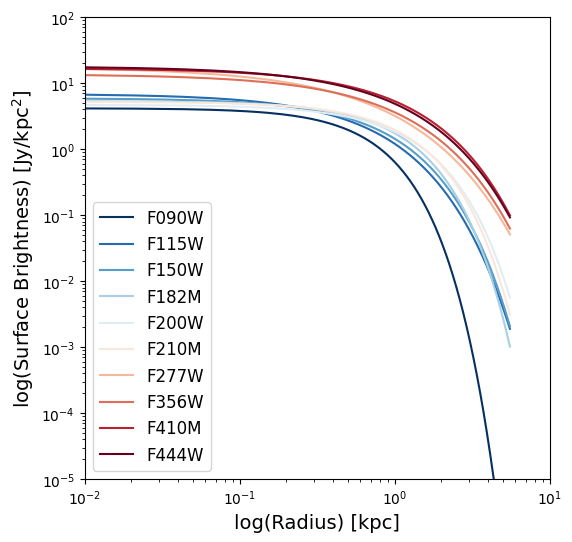

In [31]:
import matplotlib.cm as cm


# Generate a range of radii (0 to 3*r_eff)
radii = np.linspace(0.01, 3 * max(r_effs_kpc), 500)

# Create sersic models to plot
sersic_models = []
brightnesses = []
for i in range(len(filter_list)):
    sersic_model = Sersic1D(amplitude=amplitudes[i], r_eff=r_effs_kpc[i], n=sersic_indices[i])
    sersic_models.append(sersic_model)
    
    # Evaluate the Sérsic profile
    brightness = sersic_model(radii)
    brightnesses.append(brightness)

# Sort the data based on sersic_indices
# sorted_indices = np.argsort(sersic_indices)
# filter_list = np.array(filter_list)[sorted_indices]
# amplitudes = np.array(amplitudes)[sorted_indices]
# r_effs_kpc = np.array(r_effs_kpc)[sorted_indices]
# sersic_indices = np.array(sersic_indices)[sorted_indices]


plt.figure(figsize=(6, 6))
cmap = cm.get_cmap('RdBu_r', len(filter_list))  # Choose a colormap
min_index = np.argmin(r_effs_kpc)
max_index = np.argmax(r_effs_kpc)

for i in range(len(filter_list)):
    color = cmap(i / len(filter_list))
    line, = plt.plot(radii, brightnesses[i], label=f"{filter_list[i]}".upper(), color=color)
    # if i == min_index:
    #     plt.axvline(r_effs_kpc[i], color=color, linestyle='--')
    #     plt.text(r_effs_kpc[i], max(brightnesses[i]), f"min r_eff", color=color, verticalalignment='bottom')
    # if i == max_index:
    #     plt.axvline(r_effs_kpc[i], color=color, linestyle='--')
    #     plt.text(r_effs_kpc[i], max(brightnesses[i]), f"max r_eff", color=color, verticalalignment='bottom')

# plt.axvline(r_eff, color='r', linestyle='--', label=r"$r_{\text{eff}}$")
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlim([1e-2, 10])
plt.ylim([1e-5, 100])
plt.xlabel("log(Radius) [kpc]", fontsize=14)
plt.ylabel("log(Surface Brightness) [Jy/kpc$^2$]", fontsize=14)
plt.legend(prop={'size':12})
# plt.grid()
plt.savefig('brightnessprofiles.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### SVI fits, Flux v Wlgth

In [32]:
import asdf
import os

from astropy.cosmology import Planck18 as cosmo 

# Define the path to the directory containing the ASDF files
# filter_name = "f090w"
path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'
filter_list = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F277W", "F356W", "F410M", "F444W"]

for filter_name in filter_list:
    file_path = os.path.join(path_wdir, 'Output', f'4compSVI_{filter_name}.asdf')
    with asdf.open(file_path) as af:
        flux_0 = af['posterior']['flux_0'].mean()
        
        params_single = list(af['posterior'].keys())

params_single[3]

'flux_0'

In [33]:
# converting flux units:
# Flux is Energy / area
# Raw unit is MJy/sr / pixel,
# current output is "for x source, total flux is (y) MJy/sr /pixel"
# Pixel area in sr (sr / px) = PIXAR_SR
# so want flux * pixar_sr
pixar_vals = []
for i, f in enumerate(filter_list):
        # load image data
        fname = (file_core + f + '.fits')
        with fits.open(fname) as hdul:
            header = hdul[0].header
            pixar_vals.append(header['PIXAR_SR'])

print(pixar_vals)

[2.11791053341201e-14, 2.12390131173457e-14, 2.11701369095792e-14, 2.11465740855696e-14, 2.12239146123051e-14, 2.11465740855697e-14, 2.11465740855697e-14, 2.11465740855697e-14, 2.11465740855697e-14, 2.11465740855697e-14]


In [35]:
# print(flux_0s)

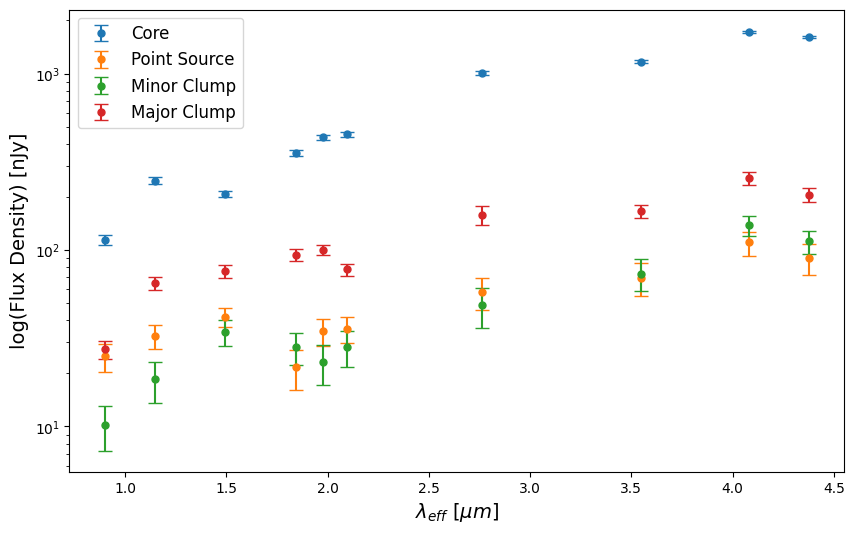

In [ ]:
import asdf
from sedpy import observate
from astropy.cosmology import Planck18 as cosmo 

# Define the path to the directory containing the ASDF files
path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'

filterlist = observate.load_filters(["jwst_" + f for f in filter_list])

wavelengths = []
for i in filterlist:
    wavelengths.append(i.wave_effective/10000)

flux_0s = []
flux_0s_errors_lower = []
flux_0s_errors_upper = []
flux_1s = []
flux_1s_errors_lower = []
flux_1s_errors_upper = []
flux_2s = []
flux_2s_errors_lower = []
flux_2s_errors_upper = []
flux_3s = []
flux_3s_errors_lower = []
flux_3s_errors_upper = []


for j, filter_name in enumerate(filter_list):
    file_path = os.path.join(path_wdir, 'Output', f'4compSVI_{filter_name}.asdf')
    with asdf.open(file_path) as af:
        params_single = list(af['posterior'].keys())
        flux_0 = af['posterior']['flux_0'].mean() * pixar_vals[j]
        flux_0s.append(flux_0)
        param_a_16 = np.percentile(np.concatenate(af['posterior']['flux_0'][:]), 16) * pixar_vals[j]
        param_a_84 = np.percentile(np.concatenate(af['posterior']['flux_0'][:]), 84) * pixar_vals[j]
        flux_0s_errors_lower.append(flux_0 - param_a_16)
        flux_0s_errors_upper.append(param_a_84 - flux_0)
        # print("low:", param_a_16)
        # print("flux:", flux_0s)
        # print("upper:", param_a_84)
        # print("calced low:", flux_0s_errors_lower)
        # print("calced upper:", flux_0s_errors_upper)

        flux_1 = af['posterior']['flux_1'].mean() * pixar_vals[j]
        flux_1s.append(flux_1)
        param_a_16 = np.percentile(np.concatenate(af['posterior']['flux_1'][:]), 16) * pixar_vals[j]
        param_a_84 = np.percentile(np.concatenate(af['posterior']['flux_1'][:]), 84) * pixar_vals[j]
        flux_1s_errors_lower.append(flux_1 - param_a_16)
        flux_1s_errors_upper.append(param_a_84 - flux_1)

        flux_2 = af['posterior']['flux_2'].mean() * pixar_vals[j]
        flux_2s.append(flux_2)
        param_a_16 = np.percentile(np.concatenate(af['posterior']['flux_2'][:]), 16) * pixar_vals[j]
        param_a_84 = np.percentile(np.concatenate(af['posterior']['flux_2'][:]), 84) * pixar_vals[j]
        flux_2s_errors_lower.append(flux_2 - param_a_16)
        flux_2s_errors_upper.append(param_a_84 - flux_2)

        flux_3 = af['posterior']['flux_3'].mean() * pixar_vals[j]
        flux_3s.append(flux_3)
        param_a_16 = np.percentile(np.concatenate(af['posterior']['flux_3'][:]), 16) * pixar_vals[j]
        param_a_84 = np.percentile(np.concatenate(af['posterior']['flux_3'][:]), 84) * pixar_vals[j]
        flux_3s_errors_lower.append(flux_3 - param_a_16)
        flux_3s_errors_upper.append(param_a_84 - flux_3)


# Convert fluxes to nJy

flux_0s = [val * 1e15 for val in flux_0s]
flux_0s_errors_lower = [err * 1e15 for err in flux_0s_errors_lower]
flux_0s_errors_upper = [err * 1e15 for err in flux_0s_errors_upper]

flux_1s = [val * 1e15 for val in flux_1s]
flux_1s_errors_lower = [err * 1e15 for err in flux_1s_errors_lower]
flux_1s_errors_upper = [err * 1e15 for err in flux_1s_errors_upper]

flux_2s = [val * 1e15 for val in flux_2s]
flux_2s_errors_lower = [err * 1e15 for err in flux_2s_errors_lower]
flux_2s_errors_upper = [err * 1e15 for err in flux_2s_errors_upper]

flux_3s = [val * 1e15 for val in flux_3s]
flux_3s_errors_lower = [err * 1e15 for err in flux_3s_errors_lower]
flux_3s_errors_upper = [err * 1e15 for err in flux_3s_errors_upper]


# Plot flux against wavelength
plt.figure(figsize=(10, 6))

size = 5

# Ideal would be blue-to-red 
plt.errorbar(wavelengths, flux_0s, yerr=[flux_0s_errors_lower, flux_0s_errors_upper], markersize=size, fmt='o', capsize=5, label='Core')
plt.errorbar(wavelengths, flux_1s, yerr=[flux_1s_errors_lower, flux_1s_errors_upper], markersize=size, fmt='o', capsize=5, label='Point Source')
plt.errorbar(wavelengths, flux_2s, yerr=[flux_2s_errors_lower, flux_2s_errors_upper], markersize=size, fmt='o', capsize=5, label='Minor Clump')
plt.errorbar(wavelengths, flux_3s, yerr=[flux_3s_errors_lower, flux_3s_errors_upper], markersize=size, fmt='o', capsize=5, label='Major Clump')
# font = {'family' : 'DejaVu sans',
#         'weight' : 'normal',
#         'size'   : 15}
# plt.rc('font', **font)
# plt.plot(wavelengths, curve_of_best_fit, 'b-', label='Best Fit Line')
plt.xlabel(r"$\lambda_{eff}$ [$\mu m$]", fontsize=14)
plt.ylabel(r'log(Flux Density) [nJy]', fontsize=14)
plt.tick_params(axis='both', labelsize=10)
# plt.title('Half-Light Radius vs Wavelength')
plt.legend(fontsize=12)
plt.yscale('log')
# plt.savefig('4compFluxWlgth.pdf', bbox_inches='tight')
plt.show()

In [40]:
import pandas as pd
print(
flux_0s_errors_lower)
print(flux_0s_errors_upper)

[np.float32(7.2485285), np.float32(11.340836), np.float32(8.888737), np.float32(14.248096), np.float32(14.889917), np.float32(15.484169), np.float32(29.140535), np.float32(28.551922), np.float32(30.291199), np.float32(29.39966)]
[np.float32(7.037109), np.float32(11.010046), np.float32(8.629463), np.float32(13.832549), np.float32(14.455749), np.float32(15.0325985), np.float32(28.290413), np.float32(27.719147), np.float32(29.4079), np.float32(28.542055)]


In [53]:
import pandas as pd
# Convert Lists to DataFrame
# Use pandas to convert the lists into a DataFrame

# Create a dictionary with the lists
data = {
    'filter': filter_list,
    'wavelength': wavelengths,
    'flux_0s': flux_0s,
    'flux_0s_delta_lower': flux_0s_errors_lower,
    'flux_0s_delta_upper': flux_0s_errors_upper,
    'flux_1s': flux_1s,
    'flux_1s_delta_lower': flux_1s_errors_lower,
    'flux_1s_delta_upper': flux_1s_errors_upper,
    'flux_2s': flux_2s,
    'flux_2s_delta_lower': flux_2s_errors_lower,
    'flux_2s_delta_upper': flux_2s_errors_upper,
    'flux_3s': flux_3s,
    'flux_3s_delta_lower': flux_3s_errors_lower,
    'flux_3s_delta_upper': flux_3s_errors_upper
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('4compSVI_fluxes_nJy.csv', index=False)
# df.iloc[:, 2:] /= 1e6
# Display the DataFrame
df

,filter,wavelength,flux_0s,flux_0s_delta_lower,flux_0s_delta_upper,flux_1s,flux_1s_delta_lower,flux_1s_delta_upper,flux_2s,flux_2s_delta_lower,flux_2s_delta_upper,flux_3s,flux_3s_delta_lower,flux_3s_delta_upper
0,F090W,0.898244,114.529900,7.248528,7.037109,24.990421,4.691790,4.395242,10.162761,2.874004,2.874655,27.308922,3.140461,3.102509
1,F115W,1.148592,247.256226,11.340836,11.010046,32.613266,5.256317,4.934231,18.490007,4.851851,4.636433,64.777336,5.819177,5.751977
2,F150W,1.494422,207.318665,8.888737,8.629463,41.726292,4.904131,4.969285,34.522293,6.020507,5.843870,75.975349,6.172472,6.146111
3,F182M,1.842362,355.220428,14.248096,13.832549,21.765066,5.742579,5.473645,28.026211,5.693781,5.839457,93.876694,6.708196,6.771934
4,F200W,1.978114,435.859680,14.889917,14.455749,34.881367,6.219451,5.857860,23.105988,5.949736,5.808488,100.104759,6.968208,7.096211
5,F210M,2.093747,453.182648,15.484169,15.032598,35.802654,6.225458,6.004559,28.346821,6.662060,6.504694,77.662651,6.181952,6.060717
6,F277W,2.761209,1006.715393,29.140535,28.290413,57.889416,11.939881,11.778230,48.572495,12.607533,12.610105,157.893967,19.640701,19.309328
7,F356W,3.548348,1169.329590,28.551922,27.719147,69.670464,14.949952,14.865089,73.575386,15.001211,15.070986,165.406631,14.185525,15.610451
8,F410M,4.079328,1718.084106,30.291199,29.407900,110.300110,17.434818,16.661985,138.552689,18.321648,18.126884,254.553864,22.256367,22.616024
9,F444W,4.378783,1610.393188,29.399660,28.542055,90.455620,17.844498,17.448771,111.820572,17.472155,17.014412,205.193069,18.183697,18.489902


## Comparative Model Plots

- Need data, residual, and model DICTS for each filter

- 1st - load .fits IM data for each filter, then
- 2nd - Load (each) model-- .asdf "best_model_params" -> HybridRenderer?
- 3rd - Compute residuals for each model... image - model = residual

In [73]:
import os
import numpy as np 
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

from pysersic.results import plot_image
from pysersic import check_input_data
from pysersic.priors import SourceProperties
from pysersic.priors import autoprior
from pysersic import FitSingle
from pysersic.loss import student_t_loss_free_sys
from pysersic.results import plot_residual
from pysersic.rendering import HybridRenderer
# from pysersic.multiband import FitMultiBandPoly # "No module named 'pysersic.multiband'"

import jax
import jax.numpy as jnp
from jax.random import (
    PRNGKey,  # Need to use a seed to start jax's random number generation
)

import corner 

import asdf

import arviz as az

from sedpy import observate 

from astropy.modeling.models import Sersic1D
from astropy.cosmology import Planck18 as cosmo

data looks good!


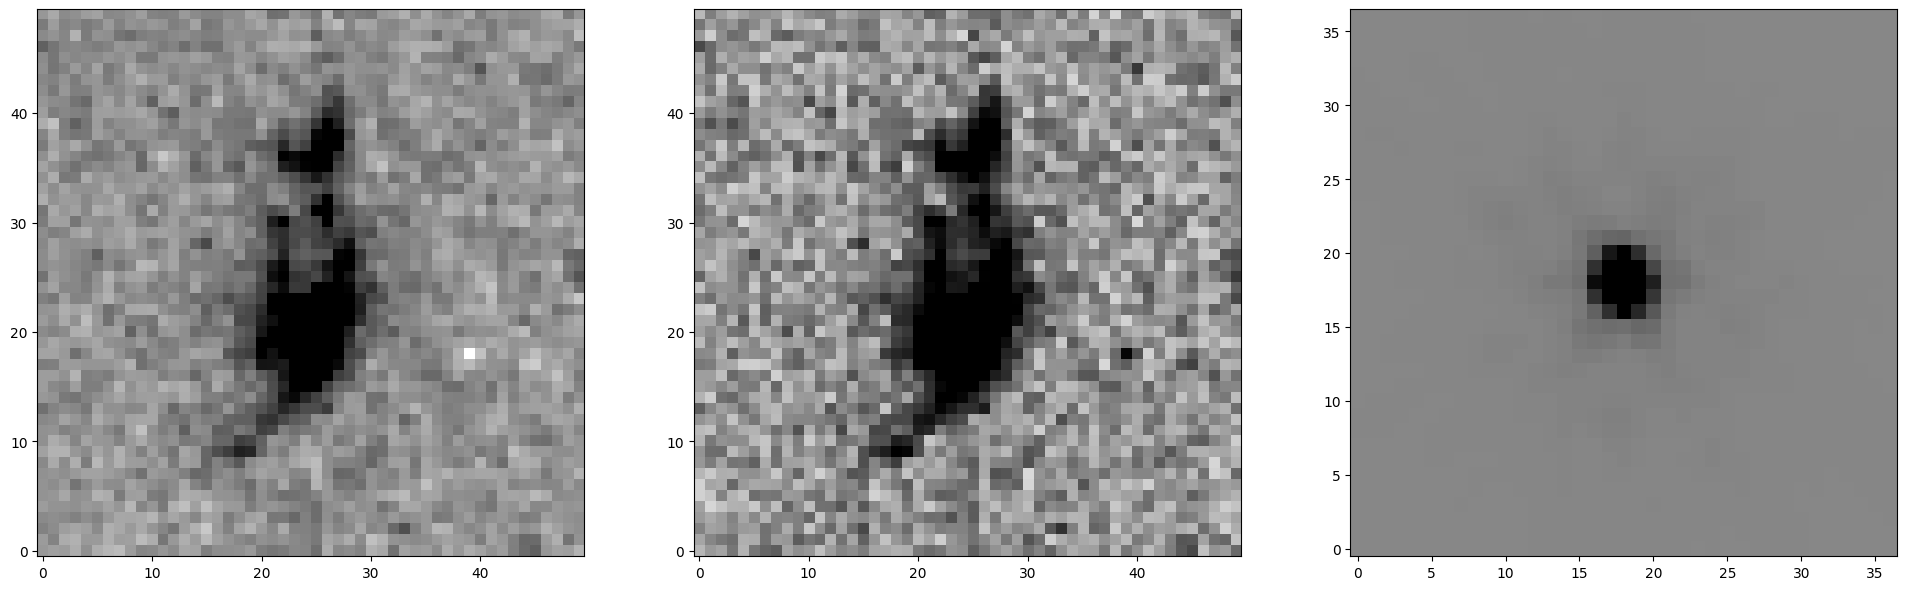

In [74]:
path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'

def load_data(filter, plot=False):

    '''
    Loading the data
    
    We'll be using three galaxies imaged by HSC for this example. The 4 needed inputs to perform a fit are
     - im: the image itself
     - mask: a mask indicating pixels which should not be included in the fit
     - sig: a map of pixel uncertainties 
     - psf: a map of the PSF (for now, only one psf can be used).
    '''

    # load image data
    fname = os.path.join(path_wdir, '191250_cutouts', '191250_' + filter.upper() + '.fits')
    im = fits.getdata(fname, 'SCI')
    wht = fits.getdata(fname, 'WHT')
    # can set sigma to ERR
    ycen, xcen = 100, 100
    im = im[xcen-22:xcen+28, ycen-25:ycen+25]
    wht = wht[xcen-22:xcen+28, ycen-25:ycen+25]
    mask = np.zeros(im.shape)
    sig = 0.01/np.sqrt(np.abs(wht)) + 0.1*np.sqrt(np.abs(im))
    sig = 0.1*np.sqrt(np.abs(im))
    header = fits.getheader(fname, 'SCI')
    
    # load the PSF data
    PSF_large = fits.getdata(os.path.join(path_wdir, 'mpsf_gds', 'mpsf_' + filter.lower() + '.fits'))
    cen = int(0.5*PSF_large.shape[0])
    psf = PSF_large[cen-18:cen+19, cen-18:cen+19]
    psf /= np.sum(psf)
    psf = psf.astype(float)

    if plot:
        # plot data
        fig, ax = plot_image(im, mask, sig, psf)
        plt.show()

    # check data
    if check_input_data(data=im, rms=sig, psf=psf, mask=mask):
        print("data looks good!")
    else:
        print("data looks bad!")

    return(im, mask, sig, psf)

# test on single filter
im, mask, sig, psf = load_data(filter='f090w')
from pysersic.results import plot_image

fig, ax = plot_image(im, mask, sig, psf)


In [75]:
# # Calculate chi-squared
# residuals = im_contiguous - bf_model
# chi_squared = np.sum((residuals / sig) ** 2)
# print(f"Chi-squared for filter ...: {chi_squared}")

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3510576247.py:28: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


Sample Residual:


(<Figure size 1300x300 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

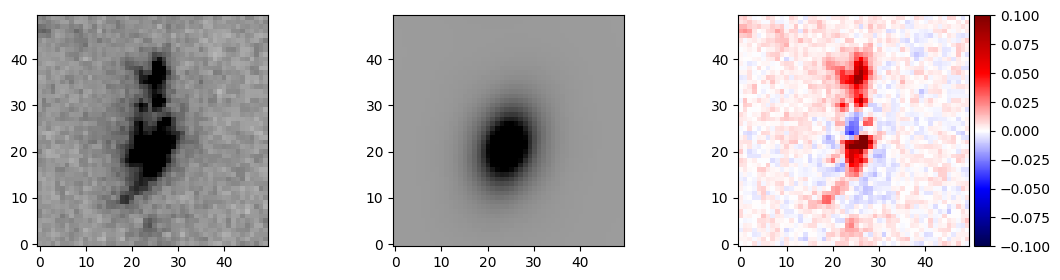

In [76]:
# Create dictionaries for IM data, each model, and residuals
filter_list = ["f090w", "f115w", "f150w", "f182m", "f200w", "f210m", "f277w", "f356w", "f410m", "f444w"]

input_dict = {}
single_models = {}
single_residuals = {}
new_dict = {}
for ii_f in filter_list:
    im, mask, sig, psf = load_data(filter=ii_f)
    input_dict[ii_f] = {'im': im, 'mask': mask, 'sig': sig, 'psf': psf}
    
    file_path = os.path.join(path_wdir, 'Output', f'fit_{ii_f}.asdf')

    af = asdf.open(file_path)

    # rms=af['input_data']['rms']
    # im=af['input_data']['image']

    posterior=af.tree['posterior']
    res = {}
    for a, b in zip(posterior.keys(), posterior.values()):
        res[a] = np.percentile(b, 50)
    new_dict[ii_f]= res	#new_dict =split_dict(res)
    #dict=af.tree

    for key, value in new_dict.items():
    #if key==0:
        single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")
print("Sample Residual:")
ii_f = 'f115w'
plot_residual(input_dict[ii_f]['im'].astype(float), single_models[ii_f], vmin=-0.1, vmax=0.1)

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:61: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: User

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:61: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: User

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:61: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: User

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model3 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_3, profile_type = 'sersic')


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:61: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: User

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:61: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: User

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:61: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: User

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:61: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: User

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:61: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: User

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:62: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\822573047.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model3 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_3, profile_type = 'sersic')


Sample Residual:


(<Figure size 1300x300 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

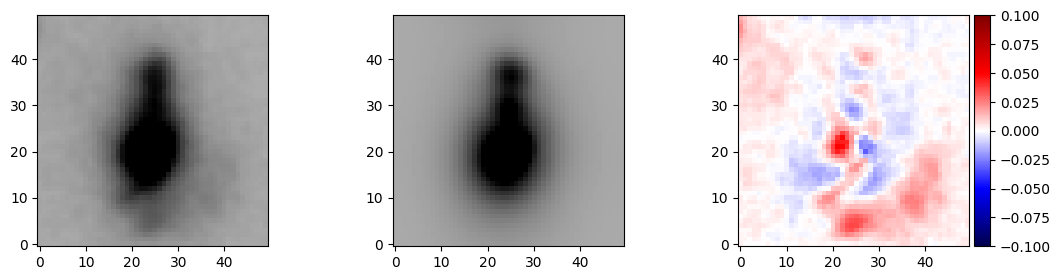

In [77]:

mcomp_dict = {}
for ii_f in filter_list:
    im, mask, sig, psf = load_data(filter=ii_f)
    input_dict[ii_f] = {'im': im, 'mask': mask, 'sig': sig, 'psf': psf}
    
    file_path = os.path.join(path_wdir, 'Output', f'4compSVI_{ii_f}.asdf')

    af = asdf.open(file_path)

    # rms=af['input_data']['rms']
    # im=af['input_data']['image']

    posterior=af.tree['posterior']
    # res = af['best_model_params'] 
    dict = {}
    for a, b in zip(posterior.keys(), posterior.values()):
        # e.g. a = ellip_0, b = array?
        dict[a] = np.percentile(b, 50)
 
    # dict = {}
    # for a, b in zip(summary.index, summary["mean"]):
    #     dict[a] = b

    dict_0 = {'xc': dict['xc_0'], 
        'yc': dict['yc_0'], 
        'r_eff': dict['r_eff_0'], 
        'n': dict['n_0'], 
        'ellip': dict['ellip_0'], 
        'flux': dict['flux_0'], 
        'theta': dict['theta_0'],
        'f_1': 1}

    dict_1 = {'xc': dict['xc_1'], 
        'yc': dict['yc_1'], 
        # 'r_eff': dict['r_eff_1'], 
        # 'n': dict['n_1'], 
        # 'ellip': dict['ellip_1'], 
        'flux': dict['flux_1'], 
        # 'theta': dict['theta_1'],
        'f_1': 1}

    dict_2 = {'xc': dict['xc_2'], 
        'yc': dict['yc_2'], 
        'r_eff': dict['r_eff_2'], 
        'n': dict['n_2'], 
        'ellip': dict['ellip_2'], 
        'flux': dict['flux_2'], 
        'theta': dict['theta_2'],
        'f_1': 1}    


    dict_3 = {'xc': dict['xc_3'], 
        'yc': dict['yc_3'], 
        'r_eff': dict['r_eff_3'], 
        'n': dict['n_3'], 
        'ellip': dict['ellip_3'], 
        'flux': dict['flux_3'], 
        'theta': dict['theta_3'],
        'f_1': 1} 

    bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
    bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
    bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
    bf_model3 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_3, profile_type = 'sersic')

    bf_model = bf_model0 + bf_model1 + bf_model2 + bf_model3
    mcomp_dict[ii_f] = bf_model
print("Sample Residual:")
ii_f = 'f444w'
plot_residual(input_dict[ii_f]['im'].astype(float), mcomp_dict[ii_f], vmin=-0.1, vmax=0.1)


C:\Users\kings\AppData\Local\Temp\ipykernel_25440\280894610.py:14: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(bf_params, profile_type = 'sersic')


(<Figure size 1300x300 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

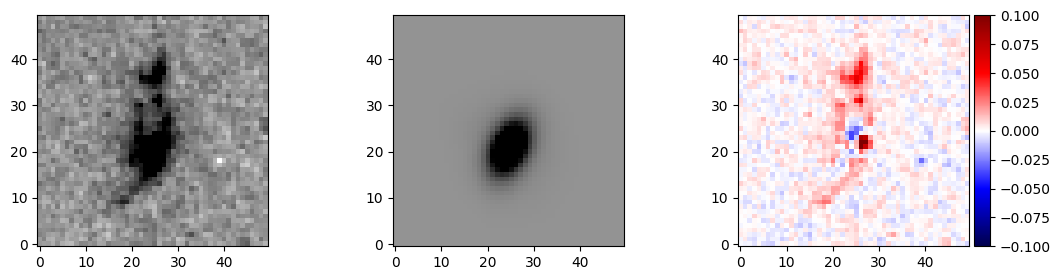

In [78]:
file_path = os.path.join(path_wdir, 'Output', f'fit_f090w.asdf')
af = asdf.open(file_path)

posterior=af.tree['posterior']
# res = af['best_model_params'] 
bf_params = {}
for a, b in zip(posterior.keys(), posterior.values()):
    # e.g. a = ellip_0, b = array?
    bf_params[a] = np.percentile(b, 50)
# bf_params = af['best_model_params']
im = af['input_data']['image']
psf = af['input_data']['psf']
bf_params
model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(bf_params, profile_type = 'sersic')
plot_residual(im.astype(float), model, vmin=-0.1, vmax=0.1)

In [79]:
single_residuals = {}
multi_residuals = {}
for ii_f in filter_list:
    singleres = input_dict[ii_f]['im'] - np.array(single_models[ii_f])
    single_residuals[ii_f] = singleres
    multires = input_dict[ii_f]['im'] -np.array(mcomp_dict[ii_f])
    multi_residuals[ii_f] = multires
    
# chi_squared = np.sum((residuals / sig) ** 2)
# print(f"Chi-squared for filter ...: {chi_squared}")


# residual = single_models[ii_f] - input_dict[ii_f]['im'].astype(float)
# plt.imshow(input_dict[ii_f]['im'], cmap='Grays', origin='lower', vmin=-0.1, vmax=0.1)
# plt.colorbar()

In [80]:
# Single residuals dict is models
ii_f = 'f444w'
chi1 = single_residuals[ii_f] / input_dict[ii_f]['sig']
chi1_squared = np.sum(chi1**2)
print(chi1_squared)

chi2 = multi_residuals[ii_f] / input_dict[ii_f]['sig']
chi2_squared = np.sum(chi2**2)
print(chi2_squared)


927.5105
562.19324


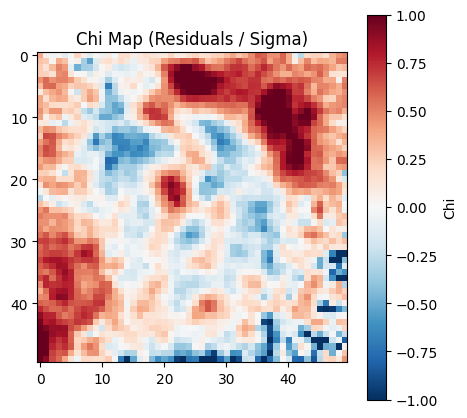

In [81]:
plt.figure(figsize=(5, 5))
plt.imshow(chi2, cmap='RdBu_r', vmin=-1, vmax=1)  # Clip extreme values for better contrast
plt.colorbar(label="Chi")
plt.title("Chi Map (Residuals / Sigma)")
plt.show()

<>:91: SyntaxWarning: invalid escape sequence '\c'
<>:91: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3152449540.py:91: SyntaxWarning: invalid escape sequence '\c'
  fig.suptitle(f'Single-Component Model; $\chi^2$ = {chi1_squared.astype(int)}', fontsize=16)


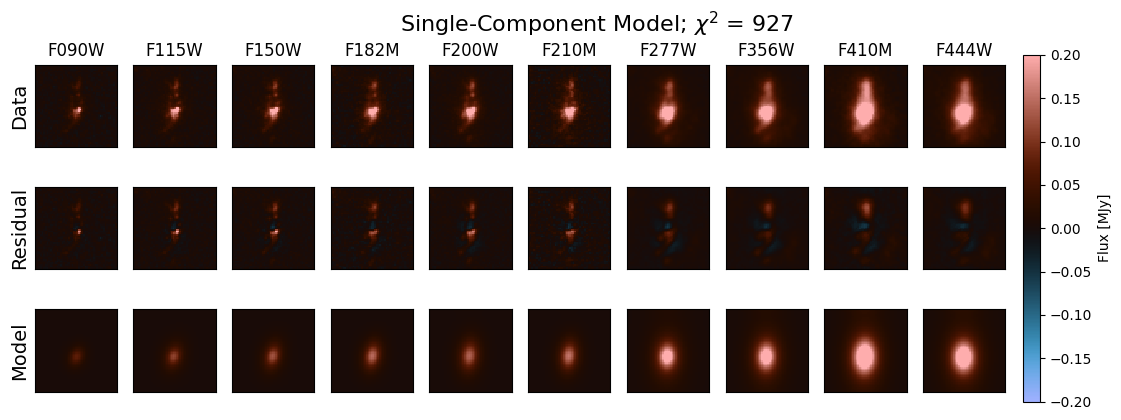

In [ ]:
from astropy.visualization import ImageNormalize, LogStretch, simple_norm

filt_list = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F277W", "F356W", "F410M", "F444W"]

fig, ax=plt.subplots(nrows=3, ncols=len(filt_list), figsize=(15, 4.5))

for i, ii_f in enumerate(filter_list):
   
    # Open data from each FITs file for each
    ims=input_dict[ii_f]['im']            #fits.open(image_list[0])[1].data
    array_res=single_residuals[ii_f]          #fits.open(res_list[0])[1].data
    array_model=single_models[ii_f]          #fits.open(mod_list[0])[1].data
    std_resid = np.std(input_dict[ii_f]['im'])

    # # Chi Values:
    # chi = single_residuals[ii_f] / input_dict[ii_f]['sig']
    # chi_squared = np.sum(chi**2)
    # print(chi_squared)

    # chi = multi_residuals[ii_f] / input_dict[ii_f]['sig']
    # chi_squared = np.sum(chi**2)
    # print(chi_squared)

    norm = ImageNormalize(vmin=-.2, vmax=.2)
    vmin, vmax= 0.001, 0.35 # std_resid * -scale, std_resid * scale

    vmin_res, vmax_res=-.3,.3
    cm='RdGy'
    cm2='berlin'

    # if i<=2:
    pl1 = ax[0,i].imshow(ims, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')
    ax[0,i].set_title(f'{filt_list[i]}', fontsize=12)
    ax[1,i].imshow(array_res, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')
    pl_res=ax[2,i].imshow(array_model, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')


    if i==len(filt_list)-1:
        
        cbar=fig.colorbar(pl_res, ax=ax[:,:],pad=0.015, label='Flux [MJy]')
        # cbar.set_label(r'Flux [nJy]', fontsize=18)

    if filt_list[i]=='F090W': 
        ax[0,i].set_ylabel('Data', fontsize=14)
        ax[1,i].set_ylabel('Residual', fontsize=14)
        ax[2,i].set_ylabel('Model', fontsize=14)

for i in range(len(ax[0,:])):
    
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].set_yticks([])

    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].set_yticks([])
    #ax[1,i].get_yaxis().set_visible(False)

    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].set_yticks([])
    #ax[2,i].get_yaxis().set_visible(False)

    fig.suptitle(f'Single-Component Model; $\chi^2$ = {chi1_squared.astype(int)}', fontsize=16)
    # fig.savefig(f'singlemodelcomparison.pdf', dpi=300, bbox_inches='tight')

<>:91: SyntaxWarning: invalid escape sequence '\c'
<>:91: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kings\AppData\Local\Temp\ipykernel_25440\3786073100.py:91: SyntaxWarning: invalid escape sequence '\c'
  fig.suptitle(f'Multi-Component Model; $\chi^2$ = {chi2_squared.astype(int)}', fontsize=16)


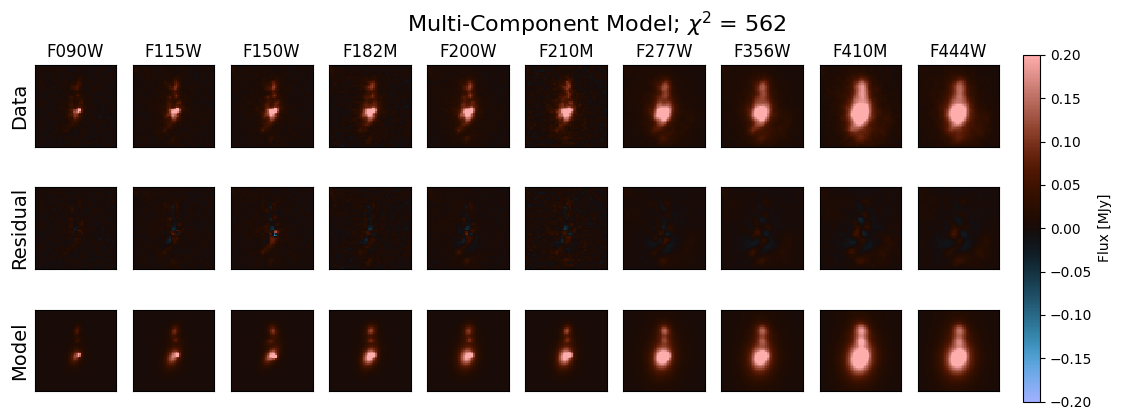

In [ ]:
from astropy.visualization import ImageNormalize, LogStretch, simple_norm

filt_list = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F277W", "F356W", "F410M", "F444W"]

fig, ax=plt.subplots(nrows=3, ncols=len(filt_list), figsize=(15, 4.5))

for i, ii_f in enumerate(filter_list):
    # Open data from each FITs file for each
    ims=input_dict[ii_f]['im']            #fits.open(image_list[0])[1].data
    array_res=multi_residuals[ii_f]          #fits.open(res_list[0])[1].data
    array_model=mcomp_dict[ii_f]          #fits.open(mod_list[0])[1].data
    std_resid = np.std(input_dict[ii_f]['im'])

    # # Chi Values:
    # chi = single_residuals[ii_f] / input_dict[ii_f]['sig']
    # chi_squared = np.sum(chi**2)
    # print(chi_squared)

    # chi = multi_residuals[ii_f] / input_dict[ii_f]['sig']
    # chi_squared = np.sum(chi**2)
    # print(chi_squared)

    norm = ImageNormalize(vmin=-.2, vmax=.2)
    vmin, vmax= 0.001, 0.35 # std_resid * -scale, std_resid * scale

    vmin_res, vmax_res=-.3,.3

    # cm='plasma'
    cm='RdGy'
    cm2='berlin'

    # if i<=2:
    pl1 = ax[0,i].imshow(ims, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')
    ax[0,i].set_title(f'{filt_list[i]}', fontsize=12)
    ax[1,i].imshow(array_res, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')
    pl_res=ax[2,i].imshow(array_model, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')


    if i==len(filt_list)-1:
        
        cbar=fig.colorbar(pl_res, ax=ax[:,:],pad=0.02, label='Flux [MJy]')
        # cbar.set_label(r'Flux [nJy]', fontsize=18)

    if filt_list[i]=='F090W': 
        ax[0,i].set_ylabel('Data', fontsize=14)
        ax[1,i].set_ylabel('Residual', fontsize=14)
        ax[2,i].set_ylabel('Model', fontsize=14)

for i in range(len(ax[0,:])):
    
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].set_yticks([])

    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].set_yticks([])
    #ax[1,i].get_yaxis().set_visible(False)

    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].set_yticks([])
    #ax[2,i].get_yaxis().set_visible(False)
    
    # from chi_check import chi_run
    # chi=chi_run(args.name, args.ids)

    fig.suptitle(f'Multi-Component Model; $\chi^2$ = {chi2_squared.astype(int)}', fontsize=16)
    fig.savefig(f'multimodelcomparison.pdf', dpi=300, bbox_inches='tight')

##### Table Makin

In [7]:

input_dict = {}
single_bf = {}
multi_bf = {}
single_residuals = {}
new_dict = {}
for ii_f in filter_list:
    file_path = os.path.join(path_wdir, 'Output', f'fit_{ii_f}.asdf')

    af = asdf.open(file_path)

    posterior=af.tree['posterior']
    res = {}
    for a, b in zip(posterior.keys(), posterior.values()):
        res[a] = np.percentile(b, 50) # res is a dict of params and their values 1:1
    res.pop('sys_rms')
    # want dict of filters with param dicts
    single_bf[ii_f.upper()] = res

    file_path2 = os.path.join(path_wdir, 'Output', f'4compSVI_{ii_f}.asdf')
    
    af = asdf.open(file_path2)

    posterior=af.tree['posterior']
    res = {}
    for a, b in zip(posterior.keys(), posterior.values()):
        res[a] = np.percentile(b, 50) # res is a dict of params and their values 1:1
    # res.pop('sys_rms')
    # want dict of filters with param dicts
    multi_bf[ii_f.upper()] = res


In [96]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(r'D:\Programming\Cambridge\4compSVI_fluxes_nJy.csv')

# Assuming your CSV columns are named like:
# 'filter', 'flux_0s', 'flux_0s_errors_lower', 'flux_0s_errors_upper', ...

# Prepare for LaTeX table rows
rows = []

# Add the header row
header = "Filter & 0 Flux & 1 Flux & 2 Flux & 3 Flux \\\\ \\hline"
rows.append(header)

# Loop through each filter and its corresponding flux and errors
for _, row in df.iterrows():
    row_data = [row['filter']]  # Filter name (assuming a column named 'filter')
    
    # Loop through fluxes and error columns (assuming they follow this pattern)
    for i in range(4):  # Assuming 4 flux components: 0, 1, 2, 3
        flux_col = f'flux_{i}s'
        lower_col = f'flux_{i}s_errors_lower'
        upper_col = f'flux_{i}s_errors_upper'

        val = row[flux_col]
        lo = row[lower_col]
        hi = row[upper_col]
        
        # Calculate asymmetric errors
        plus = hi - val
        minus = val - lo
        entry = f"${val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}$"
        
        row_data.append(entry)
    
    # Add this row to the LaTeX table rows list
    rows.append(" & ".join(row_data) + " \\\\")
# Combine everything into a full LaTeX table
latex_table = "\\begin{tabular}{lcccc}\n" + "\n".join(rows) + "\n\\end{tabular}"

# Print or save the table
print(latex_table)

\begin{tabular}{lcccc}
Filter & 0 Flux & 1 Flux & 2 Flux & 3 Flux \\ \hline
F090W & $114.53^{+-107.49}_{-107.28}$ & $24.99^{+-20.60}_{-20.30}$ & $10.16^{+-7.29}_{-7.29}$ & $27.31^{+-24.21}_{-24.17}$ \\
F115W & $247.26^{+-236.25}_{-235.92}$ & $32.61^{+-27.68}_{-27.36}$ & $18.49^{+-13.85}_{-13.64}$ & $64.78^{+-59.03}_{-58.96}$ \\
F150W & $207.32^{+-198.69}_{-198.43}$ & $41.73^{+-36.76}_{-36.82}$ & $34.52^{+-28.68}_{-28.50}$ & $75.98^{+-69.83}_{-69.80}$ \\
F182M & $355.22^{+-341.39}_{-340.97}$ & $21.77^{+-16.29}_{-16.02}$ & $28.03^{+-22.19}_{-22.33}$ & $93.88^{+-87.10}_{-87.17}$ \\
F200W & $435.86^{+-421.40}_{-420.97}$ & $34.88^{+-29.02}_{-28.66}$ & $23.11^{+-17.30}_{-17.16}$ & $100.10^{+-93.01}_{-93.14}$ \\
F210M & $453.18^{+-438.15}_{-437.70}$ & $35.80^{+-29.80}_{-29.58}$ & $28.35^{+-21.84}_{-21.68}$ & $77.66^{+-71.60}_{-71.48}$ \\
F277W & $1006.72^{+-978.42}_{-977.57}$ & $57.89^{+-46.11}_{-45.95}$ & $48.57^{+-35.96}_{-35.96}$ & $157.89^{+-138.58}_{-138.25}$ \\
F356W & $1169.33^{+-1141.

In [55]:
# Uncertainties... PLUS (upper - value); MINUS (value - lower)
# Get upper and lower bounds from asdf; use existing upper/lowwer percentile code
# Compute plus/minus for each param
# Load into dicts for each filter with correct latex format...
# flux_0s = []
# flux_0s_errors_lower = []
# flux_0s_errors_upper = []
# flux_1s = []
# flux_1s_errors_lower = []
# flux_1s_errors_upper = []
# flux_2s = []
# flux_2s_errors_lower = []
# flux_2s_errors_upper = []
# flux_3s = []
# flux_3s_errors_lower = []
# flux_3s_errors_upper = []

# Bundle into a list for iteration
flux_data = [
    (flux_0s, flux_0s_errors_lower, flux_0s_errors_upper),
    (flux_1s, flux_1s_errors_lower, flux_1s_errors_upper),
    (flux_2s, flux_2s_errors_lower, flux_2s_errors_upper),
    (flux_3s, flux_3s_errors_lower, flux_3s_errors_upper)
]

# Create LaTeX table rows
rows = []
for i, filt in enumerate(filter_list):
    row = [filt]
    for flux, err_lo, err_hi in flux_data:
        val = flux[i]
        minus = err_lo[i]
        plus = err_hi[i]
        entry = f"${val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}$"
        row.append(entry)
    rows.append(" & ".join(row) + " \\\\")
print(row[1])
# Output LaTeX table
header = "Filter & 0 Flux & 1 Flux & 2 Flux & 3 Flux \\\\ \\hline"
latex_table = "\\begin{tabular}{lcccc}\n" + header + "\n" + "\n".join(rows) + "\n\\end{tabular}"

# Save or print
print(latex_table)


$1610.39^{+28.54}_{-29.40}$
\begin{tabular}{lcccc}
Filter & 0 Flux & 1 Flux & 2 Flux & 3 Flux \\ \hline
F090W & $114.53^{+7.04}_{-7.25}$ & $24.99^{+4.40}_{-4.69}$ & $10.16^{+2.87}_{-2.87}$ & $27.31^{+3.10}_{-3.14}$ \\
F115W & $247.26^{+11.01}_{-11.34}$ & $32.61^{+4.93}_{-5.26}$ & $18.49^{+4.64}_{-4.85}$ & $64.78^{+5.75}_{-5.82}$ \\
F150W & $207.32^{+8.63}_{-8.89}$ & $41.73^{+4.97}_{-4.90}$ & $34.52^{+5.84}_{-6.02}$ & $75.98^{+6.15}_{-6.17}$ \\
F182M & $355.22^{+13.83}_{-14.25}$ & $21.77^{+5.47}_{-5.74}$ & $28.03^{+5.84}_{-5.69}$ & $93.88^{+6.77}_{-6.71}$ \\
F200W & $435.86^{+14.46}_{-14.89}$ & $34.88^{+5.86}_{-6.22}$ & $23.11^{+5.81}_{-5.95}$ & $100.10^{+7.10}_{-6.97}$ \\
F210M & $453.18^{+15.03}_{-15.48}$ & $35.80^{+6.00}_{-6.23}$ & $28.35^{+6.50}_{-6.66}$ & $77.66^{+6.06}_{-6.18}$ \\
F277W & $1006.72^{+28.29}_{-29.14}$ & $57.89^{+11.78}_{-11.94}$ & $48.57^{+12.61}_{-12.61}$ & $157.89^{+19.31}_{-19.64}$ \\
F356W & $1169.33^{+27.72}_{-28.55}$ & $69.67^{+14.87}_{-14.95}$ & $73.58^{+15.0

In [135]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
# Convert Lists to DataFrame
# Use pandas to convert the lists into a DataFrame
# Create a dictionary with the lists
data = {
    'single_bf': single_bf.values()
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(single_bf.values(), index=filter_list)
df.index = df.index.str.upper()
df.to_csv('singlecompparams.csv', index=True)